<a href="https://colab.research.google.com/github/iDRISS-DEV96/search-using-signlanguage-ai-model/blob/main/Copy_of_ASL_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# American Sign Language - MobileNetV2
Author: [Sayan Nath](https://github.com/sayannath)

Dataset Link: [Kaggle ASL](https://www.kaggle.com/grassknoted/asl-alphabet)

## Initial Setup

In [4]:
!nvidia-smi

Sat Oct 22 20:18:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install -q kaggle
!pip install -qq tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"labcharaidriss","key":"1320c6e47ed0931aa22177ce9ac7c8b4"}'}

## Data Gathering

In [7]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permissionA
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d grassknoted/asl-alphabet
!unzip -q asl-alphabet.zip

 99% 1.02G/1.03G [00:05<00:00, 154MB/s]
100% 1.03G/1.03G [00:05<00:00, 197MB/s]


In [8]:
mkdir train

In [9]:
import shutil
shutil.make_archive('dataset', 'zip', '/content/asl_alphabet_train/asl_alphabet_train')

'/content/dataset.zip'

In [10]:
!pip install patool

import patoolib
patoolib.extract_archive("dataset.zip", outdir="train/")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.3 MB/s 
patool: Extracting dataset.zip ...
patool: running /usr/bin/7z x -otrain/ -- dataset.zip
patool: ... dataset.zip extracted to `train/'.


'train/'

In [11]:
rm -rf asl_alphabet_train

## Setting up Path

In [12]:
train_dir = 'train/'

## Import the modules

In [13]:
import tensorflow as tf
tf.random.set_seed(42)

print(tf.__version__)

2.9.2


In [14]:
from imutils import paths
from pprint import pprint
from collections import Counter
import tensorflow_hub as hub
from tensorflow.keras.applications.vgg19 import VGG19 # new!
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D 

from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import re 
import os
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np
np.random.seed(42)

# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')

## Determine the dimension of the images

In [15]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_dir+'A'):
    
    img = mpimg.imread(train_dir+'A'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


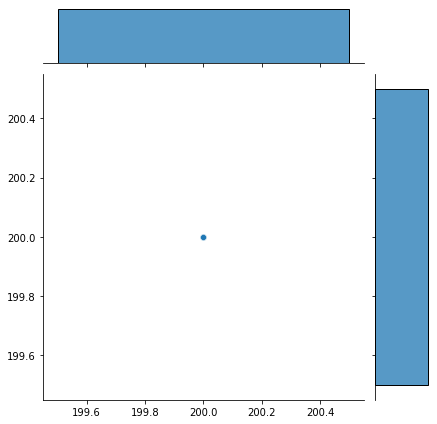

In [16]:
sns.jointplot(dim1,dim2)

In [17]:
print(np.mean(dim1))
print(np.mean(dim2))

200.0
200.0


`Height` is 200 and `Width` is 200

In [18]:
image_paths = list(paths.list_images("train"))
np.random.shuffle(image_paths)
image_paths[:5]

['train/J/J342.jpg',
 'train/L/L1118.jpg',
 'train/Q/Q865.jpg',
 'train/X/X1818.jpg',
 'train/B/B1705.jpg']

## Counting number of images per class

In [19]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'J': 3000,
         'L': 3000,
         'Q': 3000,
         'X': 3000,
         'B': 3000,
         'M': 3000,
         'A': 3000,
         'S': 3000,
         'nothing': 3000,
         'D': 3000,
         'U': 3000,
         'I': 3000,
         'F': 3000,
         'W': 3000,
         'space': 3000,
         'E': 3000,
         'del': 3000,
         'T': 3000,
         'O': 3000,
         'H': 3000,
         'K': 3000,
         'G': 3000,
         'P': 3000,
         'C': 3000,
         'N': 3000,
         'Y': 3000,
         'V': 3000,
         'R': 3000,
         'Z': 3000})


Wow! Balanced Dataset

## Define the Hyperparamteres

In [20]:
TRAIN_SPLIT = 0.9
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
EPOCHS = 10
IMG_SIZE = 224
NUM_CLASSES=29

## Splitting the dataset

In [21]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

78300 8700


## Labelling the dataset

In [22]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[ 9 11 16 23  1]


## Preprocessing the data

In [23]:
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

## Creating the `Data` Pipeline

In [24]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))
val_ds = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Define the Model

In [25]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 flatten (Flatten)           (None, 774400)            0         
                                                                 
 dense (Dense)               (None, 128)               99123328  
                                                        

## Plot

## Define the Callback

In [26]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=2, restore_best_weights=True)
]

## Train the Model

In [ ]:
model.fit(train_ds, batch_size=128, epochs=10, verbose=1, validation_data=val_ds)

# h = model.fit(train_ds,
#                validation_data=val_ds,
#                batch_size=BATCH_SIZE,
#                callbacks=train_callbacks)



Epoch 1/10
612/612 [==============================] - 730s 1s/step - loss: 2.7600 - accuracy: 0.2219 - val_loss: 1.4547 - val_accuracy: 0.5713
Epoch 2/10
612/612 [==============================] - 754s 1s/step - loss: 1.7048 - accuracy: 0.4450 - val_loss: 0.9616 - val_accuracy: 0.7126
Epoch 3/10
612/612 [==============================] - 749s 1s/step - loss: 1.4118 - accuracy: 0.5255 - val_loss: 0.8019 - val_accuracy: 0.7628
Epoch 4/10
612/612 [==============================] - 702s 1s/step - loss: 1.2145 - accuracy: 0.5846 - val_loss: 0.5908 - val_accuracy: 0.8205
Epoch 5/10
 36/612 [>.............................] - ETA: 11:12 - loss: 1.1491 - accuracy: 0.6009

## Saving our model

In [ ]:
# classifier.save('asl_model')

In [ ]:
# !du -lh asl_model

## Saving the h5 file

In [ ]:
# KERAS_ASL_FILE = 'asl.h5'
# classifier.save(KERAS_ASL_FILE)

## Helper Function - To determine the file size of our model

In [ ]:
import os
from sys import getsizeof

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) +'r' 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

Wow! 16MB

## Zipping our model together

## Testing Pipeline

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

In [ ]:
test_image_paths = (list(paths.list_images("validaion")))
print(f"Total test images: {len(test_image_paths)}")

In [ ]:
test_image_paths[:28]

In [ ]:
test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = (
    test_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
)

In [ ]:
test_predictions = np.argmax(model.predict(test_ds), 1)

In [ ]:
test_predictions.shape

In [ ]:
test_predictions[:28]

In [ ]:
test_predictions_le = le.inverse_transform(test_predictions)

In [ ]:
test_predictions_le[:28]

In [ ]:
# prediction_classes_le = le.inverse_transform(prediction_classes)
# prediction_classes_le[:28]